In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications import VGG19
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

In [2]:
import os
from imutils import paths
import cv2

LABELS = set(["Very_Mild_Demented", "Non_Demented", "Moderate_Demented", "Mild_Demented"])

# Update the dataset path
dataset_path = "C:\\Users\\naren\\OneDrive\\Desktop\\Dataset"

imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

# Loop over the image paths
for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # If the label of the current image is not part of the labels
    # you are interested in, then ignore the image
    if label not in LABELS:
        continue

    # Load the image, convert it to RGB channel ordering, and resize
    # it to be a fixed 224x224 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Update the data and labels lists, respectively
    data.append(image)
    labels.append(label)


In [3]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
 test_size=0.25, stratify=labels, random_state=42)

In [4]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [5]:
# load the VGG19 network, ensuring the head FC layer sets are left
# off
headmodel = VGG19(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
moodel = Model(inputs=headmodel.input, outputs=model)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in headmodel.layers:
    layer.trainable = False

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a checkpoint callback
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',  # You can choose a different metric to monitor
    mode='min',  # Depending on whether you want to minimize or maximize the monitored metric
    verbose=1
)

# compile our model (this needs to be done after setting our
# layers to being non-trainable)
opt = Adam(lr=1e-3)
moodel.compile(loss="categorical_crossentropy", optimizer=opt,
               metrics=["accuracy"])

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=35,
    callbacks=[model_checkpoint]  # Include the ModelCheckpoint callback
)

# To resume training later
# Load the saved weights
moodel.load_weights(checkpoint_filepath)

# Continue training from where it left off
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=remaining_epochs,  # Set the number of remaining epochs
    callbacks=[model_checkpoint]  # Include the ModelCheckpoint callback
)


C:\Users\naren\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/35
75/75 [==============================] - ETA: 0s - loss: 2.0433 - accuracy: 0.4706 
Epoch 1: val_loss improved from inf to 1.03115, saving model to model_checkpoint.h5
75/75 [==============================] - 982s 13s/step - loss: 2.0433 - accuracy: 0.4706 - val_loss: 1.0311 - val_accuracy: 0.5025
Epoch 2/35
75/75 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.5223 
Epoch 2: val_loss improved from 1.03115 to 0.93427, saving model to model_checkpoint.h5
75/75 [==============================] - 982s 13s/step - loss: 1.0212 - accuracy: 0.5223 - val_loss: 0.9343 - val_accuracy: 0.5325
Epoch 3/35
75/75 [==============================] - ETA: 0s - loss: 0.9580 - accuracy: 0.5340 
Epoch 3: val_loss improved from 0.93427 to 0.89499, saving model to model_checkpoint.h5
75/75 [==============================] - 1035s 14s/step - loss: 0.9580 - accuracy: 0.5340 - val_loss: 0.8950 - val_accuracy: 0.5838
Epoch 4/35
75/75 [==============================] - ETA: 0s -

NameError: name 'remaining_epochs' is not defined

In [21]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Assuming 'resized_testX' is your test data with shape (64, 128, 128, 3)
# Resize it to match the expected input shape of the model (224, 224, 3)
resized_testX = np.array([cv2.resize(img, (224, 224)) for img in resized_testX])


# Load the model
model_path = r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\activity_model.h5"
loaded_model = load_model(model_path)

# Compile the model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now, you can use 'loaded_model' for predictions
predictions = loaded_model.predict(resized_testX, batch_size=64)


25/25 [==============================] - 282s 11s/step


25/25 [==============================] - 287s 11s/step
                    precision    recall  f1-score   support

     Mild_Demented       0.58      0.42      0.49       224
 Moderate_Demented       1.00      0.56      0.72        16
      Non_Demented       0.74      0.77      0.76       800
Very_Mild_Demented       0.62      0.65      0.64       560

          accuracy                           0.68      1600
         macro avg       0.73      0.60      0.65      1600
      weighted avg       0.68      0.68      0.68      1600



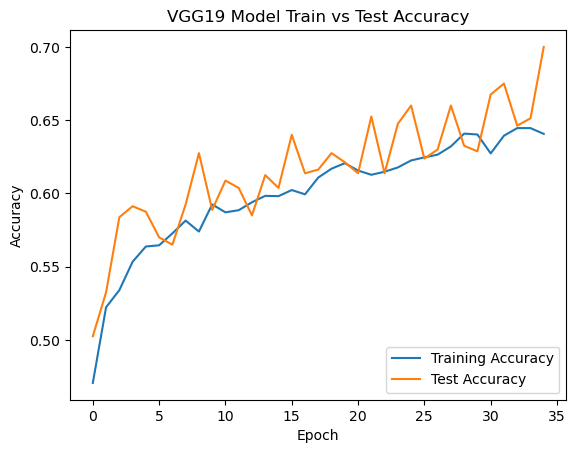

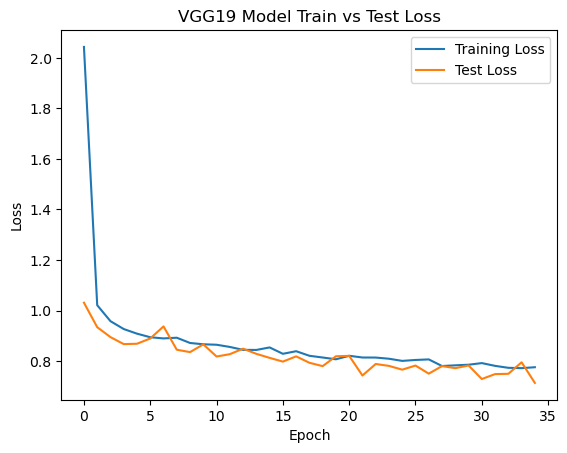

<Figure size 640x480 with 0 Axes>

In [26]:
# evaluate the network
predictions = moodel.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = 35
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG19 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\Accuracy_Plot.png")

# Plot the training and test loss
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG19 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\Loss_Plot.png")





In [27]:
#Save the Model and label file to Disk
moodel.save(r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\activity_model.h5")
f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close()

In [31]:
label_path = r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\label"

moodel.save(model_path)
with open(label_path, 'wb') as f:
    f.write(pickle.dumps(lb))

In [35]:
# Save the label binarizer to a file
label_path = r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\lb.pickle"
with open(label_path, 'wb') as f:
    f.write(pickle.dumps(lb))

In [36]:
from keras.models import load_model
import cv2
import os
import numpy as np
from collections import deque


# Load the trained model and label binarizer from disk
model_path = r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\activity_model.h5"
label_path = r"C:\Users\naren\OneDrive\Desktop\Dataset\alzheimers\label"

moodel = load_model(model_path)
lb = pickle.loads(open(label_path, "rb").read())

# Initialize the image mean for mean subtraction along with the predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)

# Specify the directory containing your dataset
dataset_directory = "C:\\Users\\naren\\OneDrive\\Desktop\\Dataset"

# Loop over all image files in the dataset directory
for filename in os.listdir(dataset_directory):
    if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
        # Construct the full path to the image file
        image_path = os.path.join(dataset_directory, filename)

        # Read the input image
        frame = cv2.imread(image_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224)).astype("float32")
        frame -= mean

        # Make predictions
        preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
        Q.append(preds)
        results = np.array(Q).mean(axis=0)
        i = np.argmax(results)
        label = lb.classes_[i]
        text = "PREDICTION for {}: {}".format(filename, label.upper())

      
        print(text)



In [37]:
!pip install flask


In [38]:
from flask import Flask, render_template, request
from keras.models import load_model
import pickle
import cv2
import numpy as np
from werkzeug.utils import secure_filename
from collections import deque
import os

app = Flask(__name__)

# Load the trained model and label binarizer from disk
model_path = "C:\\Users\\naren\\OneDrive\\Desktop\\Dataset\\alzheimers\\activity_model.h5"
label_path = "C:\\Users\\naren\\OneDrive\\Desktop\\Dataset\\alzheimers\\lb.pickle"

moodel = load_model(model_path)
lb = pickle.loads(open(label_path, "rb").read())

# Initialize the image mean for mean subtraction along with the predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)

# Define the upload folder and allowed extensions
UPLOAD_FOLDER = 'uploads'
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Function to check if the file has an allowed extension
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

# Define a route for the main page
@app.route('/')
def index():
    return render_template('index.html')

# Define a route for the prediction
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return render_template('index.html', error='No file part')

    file = request.files['file']

    if file.filename == '':
        return render_template('index.html', error='No selected file')

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        # Read the input image
        frame = cv2.imread(filepath)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224)).astype("float32")
        frame -= mean
        preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
        Q.append(preds)
        results = np.array(Q).mean(axis=0)
        i = np.argmax(results)
        label = lb.classes_[i]
        prediction = label.upper()

        return render_template('index.html', prediction=prediction, filename=filename)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\naren\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Prediction</title>
</head>
<body>
    <h1>Image Prediction</h1>
    {% if prediction %}
        <p>Prediction for {{ filename }}: {{ prediction }}</p>
    {% endif %}
    <form action="/predict" method="post" enctype="multipart/form-data">
        <label for="file">Choose an image:</label>
        <input type="file" id="file" name="file" accept=".jpg, .jpeg, .png">
        <br>
        <input type="submit" value="Predict">
    </form>
    {% if error %}
        <p style="color: red;">{{ error }}</p>
    {% endif %}
</body>
</html>
"""


In [ ]:
app.run(debug=True)
